<a href="https://colab.research.google.com/github/msadeghi322/DeepLearning/blob/main/NMA_LinearDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Deep Learning

In [1]:
# Imports
import torch
import numpy as np
from torch import nn
from math import pi
import matplotlib.pyplot as plt

In [2]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # Interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [3]:
# @title Plotting functions

from mpl_toolkits.axes_grid1 import make_axes_locatable

def ex3_plot(model, x, y, ep, lss):
  """
  Plot training loss

  Args:
    model: nn.module
      Model implementing regression
    x: np.ndarray
      Training Data
    y: np.ndarray
      Targets
    ep: int
      Number of epochs
    lss: function
      Loss function

  Returns:
    Nothing
  """
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  ax1.set_title("Regression")
  ax1.plot(x, model(x).detach().numpy(), color='r', label='prediction')
  ax1.scatter(x, y, c='c', label='targets')
  ax1.set_xlabel('x')
  ax1.set_ylabel('y')
  ax1.legend()

  ax2.set_title("Training loss")
  ax2.plot(np.linspace(1, epochs, epochs), losses, color='y')
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("MSE")

  plt.show()


def ex1_plot(fun_z, fun_dz):
  """
  Plots the function and gradient vectors

  Args:
    fun_z: f.__name__
      Function implementing sine function
    fun_dz: f.__name__
      Function implementing sine function as gradient vector

  Returns:
    Nothing
  """
  x, y = np.arange(-3, 3.01, 0.02), np.arange(-3, 3.01, 0.02)
  xx, yy = np.meshgrid(x, y, sparse=True)
  zz = fun_z(xx, yy)
  xg, yg = np.arange(-2.5, 2.6, 0.5), np.arange(-2.5, 2.6, 0.5)
  xxg, yyg = np.meshgrid(xg, yg, sparse=True)
  zxg, zyg = fun_dz(xxg, yyg)

  plt.figure(figsize=(8, 7))
  plt.title("Gradient vectors point towards steepest ascent")
  contplt = plt.contourf(x, y, zz, levels=20)
  plt.quiver(xxg, yyg, zxg, zyg, scale=50, color='r', )
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  cbar = plt.colorbar(contplt, cax=cax)
  cbar.set_label('$z = h(x, y)$')

  plt.show()

In [4]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [5]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [ ]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


(0.5970024991668155, 0.19900083305560518)


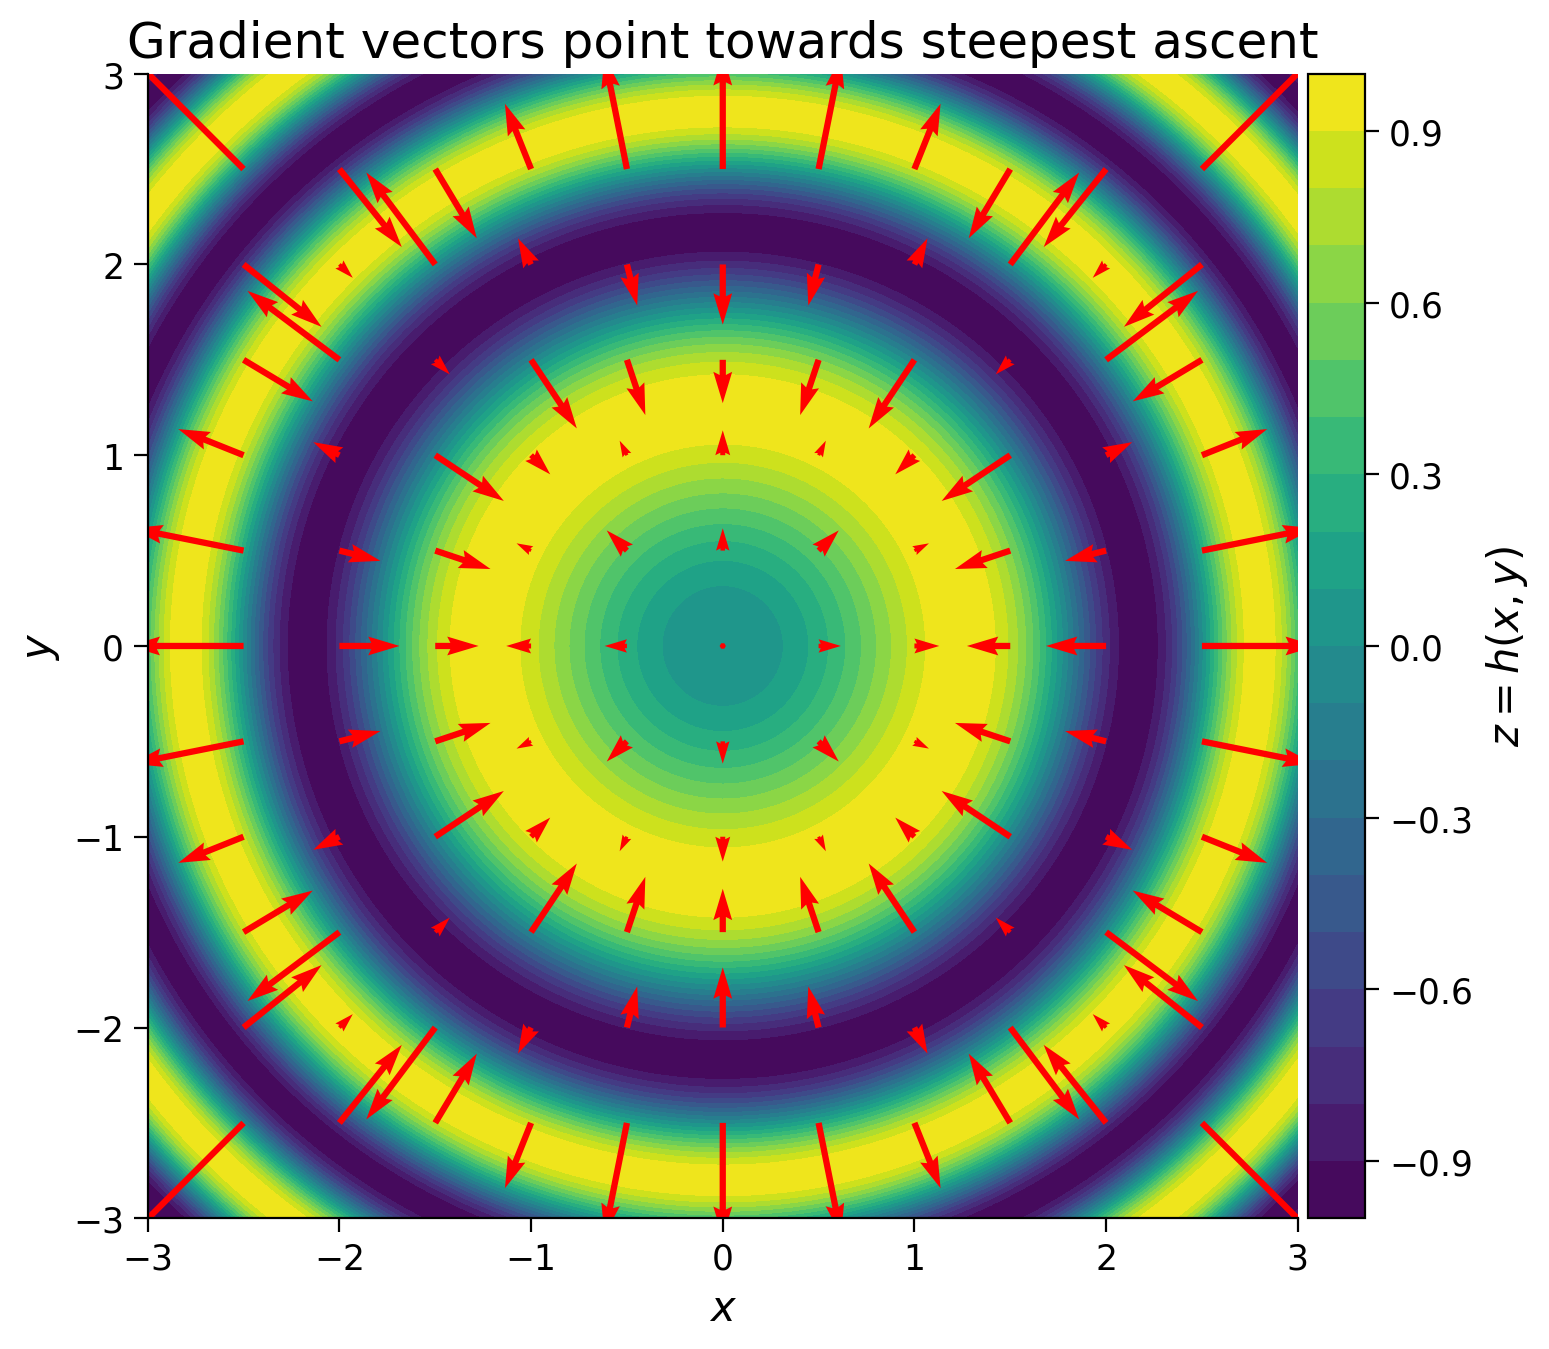

In [16]:
# @title An example Gradient Vector
def fun_z(x, y):
  """
  Implements function sin(x^2 + y^2)

  Args:
    x: (float, np.ndarray)
      Variable x
    y: (float, np.ndarray)
      Variable y

  Returns:
    z: (float, np.ndarray)
      sin(x^2 + y^2)
  """
  z = np.sin(x**2 + y**2)
  return z


def fun_dz(x, y):
  """
  Implements function sin(x^2 + y^2)

  Args:
    x: (float, np.ndarray)
      Variable x
    y: (float, np.ndarray)
      Variable y

  Returns:
    Tuple of gradient vector for sin(x^2 + y^2)
  """

  dz_dx = 2 * x * np.cos(x**2 + y**2)
  dz_dy = 2 * y * np.cos(x**2 + y**2)
  return (dz_dx, dz_dy)


## Uncomment to run
print(fun_dz(.3,.1))

ex1_plot(fun_z, fun_dz)

### Computational Graph for differentiation
Pytorch uses sophisticated algorithms that do automatic differentiation via computational graph. Comp graphs are simply broken-down computations in blocks, where the input goes in, and goes through different blocks- each block does a simple operation and passes the output to the next block, until the last block. This makes differentiation based on the chain rule easier. When we define a function, all we need to do is to declare its parameters (those that we want to learn) as learnable/trainable parameters, and then pytorch would know to take the differentiaiton wrt those parameters in the graph.


In [25]:
# @title A simple computational graph in pytorch { run: "auto" }
## A simple graph for a single neuron with parameters w (weight) and b (bias)

class SimpleGraph:

  # initialize
  def __init__(self, w , b):

    # w: initial value for weight - type: float
    # b : initial value for bias - type: float

    assert isinstance(w, float)
    assert isinstance(b, float)

    self.w = torch.tensor([w],requires_grad=True)
    self.b = torch.tensor([b], requires_grad=True)

  def forward(self, x):
    assert isinstance(x, torch.Tensor)

    prediction = torch.tanh(self.w * x + self.b)
    return prediction



def sq_loss(y_true, y_prediction):
  assert isinstance(y_true, torch.Tensor)
  assert isinstance(y_prediction, torch.Tensor)
  loss = (y_true-y_prediction)**2
  return loss

feature = torch.tensor([1])  # Input tensor (x)
target = torch.tensor([7])  # Target tensor (y)
simple_graph = SimpleGraph(-0.5, 0.5)
print(f"initial weight = {simple_graph.w.item()}, "
      f"\ninitial bias = {simple_graph.b.item()}")
prediction = simple_graph.forward(feature)
square_loss = sq_loss(target, prediction)
print(f"for x={feature.item()} and y={target.item()}, "
      f"prediction={prediction.item()}, and L2 Loss = {square_loss.item()}")

print(prediction.grad_fn)


initial weight = -0.5, 
initial bias = 0.5
for x=1 and y=7, prediction=0.0, and L2 Loss = 49.0


In [26]:
a = torch.tensor([1.0], requires_grad=True)
b = torch.tensor([2.0], requires_grad=True)
c = a ** b
print(c)
print(c.item())
print(c.grad_fn)

# Analytical gradients (Remember detaching)
ana_dloss_dw = - 2 * feature * (target - prediction.detach())*(1 - prediction.detach()**2)
ana_dloss_db = - 2 * (target - prediction.detach())*(1 - prediction.detach()**2)

square_loss.backward()  # First we should call the backward to build the graph
autograd_dloss_dw = simple_graph.w.grad  # We calculate the derivative w.r.t weights
autograd_dloss_db = simple_graph.b.grad  # We calculate the derivative w.r.t bias

print(ana_dloss_dw == autograd_dloss_dw)
print(ana_dloss_db == autograd_dloss_db)

tensor([1.], grad_fn=<PowBackward1>)
1.0
tensor([True])
tensor([True])


### Important Notes:

Learnable parameters (i.e. `requires_grad` tensors) are “contagious”. Let’s look at a simple example: `Y = W @ X`, where X is the feature tensors and W is the weight tensor (learnable parameters, `requires_grad`), the newly generated output tensor Y will be also `requires_grad`. So any operation that is applied to Y will be part of the computational graph. Therefore, if we need to plot or store a tensor that is `requires_grad`, we must first `.detach()` it from the graph by calling the `.detach()` method on that tensor.

`.backward()` accumulates gradients in the leaf nodes (i.e., the input nodes to the node of interest). We can call `.zero_grad()` on the loss or optimizer to zero out all .grad attributes (see autograd.backward for more information).

Recall that in python we can access variables and associated methods with .method_name. You can use the command `dir(my_object)` to observe all variables and associated methods to your object, e.g., dir(simple_graph.w).


PyTorch provides us with ready-to-use neural network building blocks, such as layers (e.g., linear, recurrent, etc.), different activation and loss functions, and much more, packed in the `torch.nn` module. **If we build a neural network using `torch.nn` layers, the weights and biases are already in `requires_grad` mode and will be registered as model parameters.**

### Training loop in Pytorch
